# Imports

In [ ]:
!pip install -q transformers
!pip install -q bitsandbytes
!pip install -q peft
!pip install -q torch
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 16.7 MB/s eta 0:00:00


In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments

import os
import torch
import torch.nn as nn
import bitsandbytes as bnb
import transformers
import peft

# Setting Up Model

In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# Freezing the model
for param in model.parameters():
  param.requires_grad = False
  if param.ndim == 1:
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from peft import LoraConfig, PromptEncoderConfig, PromptTuningConfig, get_peft_model, TaskType, PromptTuningInit

config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM,
    prompt_tuning_init=PromptTuningInit.TEXT,
    num_virtual_tokens=20,
    prompt_tuning_init_text="Write your answer as if you are Sherklock Holmes:",
    tokenizer_name_or_path="gpt2",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 15360 || all params: 124455168 || trainable%: 0.012341793632868666


In [ ]:
data = []
with open("parsed_quotes_context.txt") as sherlock_quotes_file:
    lines = sherlock_quotes_file.readlines()
    for i in range(0, len(lines), 3):
        if i + 1 < len(lines):
            concatenated_lines = f"{lines[i].strip()} ->: {lines[i+1].strip()}"
            data.append(concatenated_lines)

In [ ]:
data[1]

'Well -- ah - -well you could straighten up this room. It looks more like a pig sty every day. ->: Oh, very well - (yawns)'

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=50)

train_data = [tokenizer(line) for line in train_data]
val_data = [tokenizer(line) for line in val_data]

# Training Model

In [ ]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=1000,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        evaluation_strategy="steps",
        eval_steps=20,
        output_dir='outputs',
        save_steps=250,
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.980800,4.485101
40,5.019100,4.467590
60,4.701600,4.432567
80,4.737900,4.382558
100,4.703400,4.321553
120,4.720100,4.268754
140,4.482600,4.224971
160,4.340300,4.188761
180,4.656000,4.166418
200,4.559100,4.152239


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=1000, training_loss=4.367575531005859, metrics={'train_runtime': 369.0242, 'train_samples_per_second': 43.358, 'train_steps_per_second': 2.71, 'total_flos': 648187960320000.0, 'train_loss': 4.367575531005859, 'epoch': 23.39})

# Testing Model

In [ ]:
from transformers import set_seed

set_seed(40)

device = model.device
batch = tokenizer("Where is the criminal? ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=125,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/peft/peft_model.py:1081: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")


Output:
----------------------------------------------------------------------------------------------------
0: Where is the criminal? ->: ********/ (I wonder if they were talking to you in the middle of a dinner.) ->: ********/ (You don't have a clue. He doesn't know anything. He just looks like he wants to look at the book. What? He thinks you are reading it? But they can't see you; he can't see who is reading it.)


In [ ]:
from transformers import set_seed

set_seed(40)

device = model.device
batch = tokenizer("Who is that figure? ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=125,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: Who is that figure? ->: ********/ (I wonder if they were talking to you in the middle of a dinner.)- Mrs. O'Brien ->: ********/ (Mrs. O'Brien is just as nervous about me as she is in an office; she doesn't seem to mind if she gets a quick look at me.)- Mrs. O'Brien ->: ********/ (She's not very nervous or annoyed at all.)- Mrs. O'Brien ->: ********/ (Mrs. O'Brien doesn't seem to bother me at all. I suspect she just wants to be on her toes with a picture.)


In [ ]:
from transformers import set_seed

set_seed(40)

device = model.device
batch = tokenizer("How can we find the culprit? ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=125,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How can we find the culprit? ->: ********/How can we find the culprit?-> Why did you look at me...? ->: ********/Did you feel the cold of a mirror? ->: ********/Did you feel the cold of a mirror? ->: What did you see? ->: What had you seen? ->: What had you seen? ->: I was out, I'm out.->: ********/What happened to all the children... ->: What happened to all the children...? ->: I was looking out from the fireplace, and I found my missing child, too.->: I was looking for another child,


# Analyzing Model

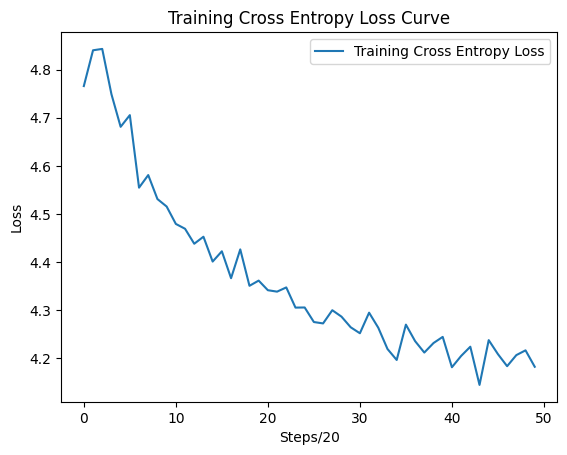

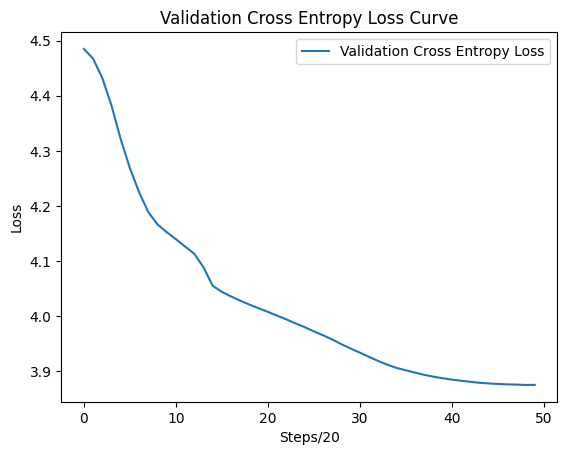

In [ ]:
import matplotlib.pyplot as plt

train_loss_values = []
val_loss_values = []

# Access the training and val loss values from the Trainer's log
for i, x in enumerate(trainer.state.log_history[:-1]):
  if (i+1) % 21 == 0:
    val_loss_values.append(x["eval_loss"])
  else:
    train_loss_values.append(x["loss"])
train_loss_values = [sum(train_loss_values[i:i+20]) / 20 for i in range(0, len(train_loss_values), 20)]

# Plot the training loss curve
plt.plot(train_loss_values, label="Training Cross Entropy Loss")
plt.xlabel("Steps/20")
plt.ylabel("Loss")
plt.title("Training Cross Entropy Loss Curve")
plt.legend()
plt.show()

# Plot the val loss curve
plt.plot(val_loss_values, label="Validation Cross Entropy Loss")
plt.xlabel("Steps/20")
plt.ylabel("Loss")
plt.title("Validation Cross Entropy Loss Curve")
plt.legend()
plt.show()

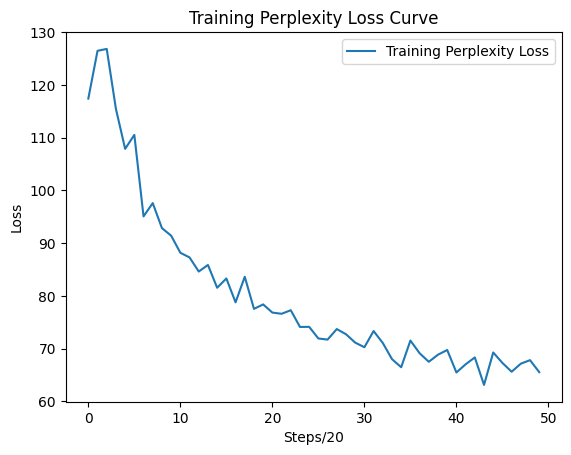

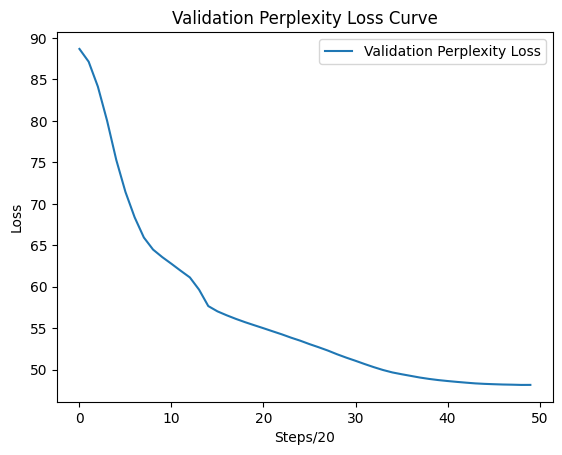

In [ ]:
import numpy as np
perplexity_train_loss_values = [np.exp(x) for x in train_loss_values]
perplexity_val_loss_values = [np.exp(x) for x in val_loss_values]

# Plot the training loss curve
plt.plot(perplexity_train_loss_values, label="Training Perplexity Loss")
plt.xlabel("Steps/20")
plt.ylabel("Loss")
plt.title("Training Perplexity Loss Curve")
plt.legend()
plt.show()

# Plot the validation loss curve
plt.plot(perplexity_val_loss_values, label="Validation Perplexity Loss")
plt.xlabel("Steps/20")
plt.ylabel("Loss")
plt.title("Validation Perplexity Loss Curve")
plt.legend()
plt.show()